# Path

### Main path class

In [2]:
import numpy as np
import scipy.interpolate as interp
import matplotlib.pyplot as plt
import time
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
from scipy.integrate import cumtrapz
from scipy.spatial import cKDTree
from shapely.geometry import Polygon, Point, LineString
import pickle

In [5]:
import numpy as np
import scipy.interpolate as interp
import matplotlib.pyplot as plt
import time
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
from scipy.integrate import cumtrapz
from scipy.spatial import cKDTree
from shapely.geometry import Polygon, Point, LineString
import pickle

np.seterr(all='ignore')
np.set_printoptions(precision=3, suppress=True)

class Path():
    def __init__(self,
                 trajectory_point_interval=0.1,
                 No=12,
                 Nw=8,
                 Lp=15,
                 mu_r=0.25,
                 sigma_d=0.8,
                 shift_distance=5.0,
                 extend_length = 2.0,
                 look_ahead_distance= 1.0):
        
        self.interval = trajectory_point_interval
        self.No=No
        self.Nw=Nw
        self.Lp=Lp
        self.mu_r=mu_r
        self.sigma_d=sigma_d
        
        self.shift_distance = shift_distance
        self.extend_length = extend_length
        
        self.look_ahead_distance = Lp * 0.2 #look_ahead_distance
    def generate_waypoints_not_back(self, Nw, Lp):
        """
        This method generates random waypoints that won't go back
        """
        # Generate the starting point
        theta_start = np.random.uniform(0, 2 * np.pi)
        p_start = 0.5 * Lp * np.array([np.cos(theta_start), np.sin(theta_start)])
        waypoints = [p_start]

        # Calculate the average segment length
        avg_segment_length = Lp / (Nw - 1)

        # Generate the remaining waypoints
        for i in range(1, Nw):  # Nw - 1 to leave space for the last waypoint (p_end)
            # Get the previous waypoint and the direction of the previous segment
            prev_waypoint = waypoints[-1]
            if i == 1:
                prev_dir = np.array([1, 0])
            else:
                prev_dir = prev_waypoint - waypoints[-2]
            
            # Generate a new waypoint in the forward direction
            while True:
                # Generate a random direction vector
                direction = np.random.rand(2) - 0.5
                direction /= np.linalg.norm(direction)

                # Check if the new waypoint is in the forward direction
                if np.dot(direction, prev_dir) >= 0:
                    break
            
            # Generate a new waypoint at the average segment length and add it to the list
            new_waypoint = prev_waypoint + avg_segment_length * direction
            waypoints.append(new_waypoint)

        self.waypoints =  np.array(waypoints)

    def generate_path_colav_environment(self, No, Nw, Lp, mu_r, sigma_d):
    
        # Create smooth arc length parameterized path using PCHIP
        p = interp.PchipInterpolator(np.linspace(0, 1, Nw), self.waypoints, axis=0)

        obstacles = []

        # Generate No obstacles
        for _ in range(No):
            # Draw arclength omega_obst from Uniform(0.1 * Lp, 0.9 * Lp)
            omega_obst = np.random.uniform(0.1 * Lp, 0.9 * Lp)

            # Map omega_obst to normalized arclength
            norm_omega_obst = omega_obst / Lp

            # Draw obstacle displacement distance d_obst from N(0, sigma_d^2)
            d_obst = np.random.normal(0, sigma_d**2)

            # Path angle gamma_obst
            gamma_obst = np.arctan2(p.derivative()(norm_omega_obst)[1], p.derivative()(norm_omega_obst)[0])

            # Obstacle position
            p_obst = p(norm_omega_obst) + d_obst * np.array([np.cos(gamma_obst - np.pi/2), np.sin(gamma_obst - np.pi/2)])

            # Draw obstacle radius r_obst from Poisson(mu_r)
            # r_obst = np.clip(np.random.normal(mu_r, 0.3), 0.1, 1)
            r_obst = mu_r # temporary using a fix radius
            # Add obstacle (p_obst, r_obst) to environment
            obstacles.append((p_obst, r_obst))

        return p, obstacles
    
    def arc_length(self, path, t, dt):
        derivative = path.derivative()(t)
        return np.sqrt(np.sum(derivative**2, axis=1)) * dt
    
    def generate_path(self):
        self.generate_waypoints_not_back(self.Nw, self.Lp)
        path, self.obstacles = self.generate_path_colav_environment(self.No, self.Nw, self.Lp, self.mu_r, self.sigma_d)
        self.obstacles_np = np.array([list(t[0]) + [t[1]] for t in self.obstacles])

        # Calculate even trajectory points
        t = np.linspace(0, 1, 1000)
        dt = t[1] - t[0]
        cumulative_arclength = np.cumsum(self.arc_length(path, t, dt))
        point_distance = self.interval
        total_arclength = cumulative_arclength[-1]
        num_points = int(np.ceil(total_arclength / point_distance))
        even_t = np.zeros(num_points)
        current_arclength = 0
        for i in range(1, num_points):
            current_arclength += point_distance
            even_t[i] = np.interp(current_arclength, cumulative_arclength, t)
            
        # get even trajectory
        self.even_trajectory = path(even_t)
        self.even_trajectory = np.vstack((self.even_trajectory, self.waypoints[-1])) # add the last waypoint into even_trajectory
        self.trejectory_kd_tree = cKDTree(self.even_trajectory.copy())
        
        # Calculate the length of the trajectory at each point
        differences = np.linalg.norm(np.diff(self.even_trajectory, axis=0), axis=1)
        self.trajectory_length_at_each_point = np.cumsum(differences)
        self.even_trajectory = self.even_trajectory[1:] # remove the first point in even_trajectory after calculate the trajectory length
        
        # Calculate yaw angles at each point
        path_derivative = path.derivative()(even_t)
        self.yaw_angles = np.arctan2(path_derivative[:, 1], path_derivative[:, 0])
        
    
    def generate_walls(self):
        """
        Generate the boundary of the environment
        """
        points = self.even_trajectory.copy()
        # Shift the trajectories
        shifted_points_up, shifted_points_down = self.shift_trajectory_local(points, self.shift_distance)
        # Smooth and resample the shifted trajectories
        target_distance = 0.1
        resampled_shifted_points_up, resampled_shifted_points_down = self.smooth_and_resample_trajectories(shifted_points_up, shifted_points_down, target_distance)

        # Extend the resampled trajectories
        extend_length = 2
        extended_resampled_shifted_points_up = self.extend_trajectory(resampled_shifted_points_up, extend_length)
        extended_resampled_shifted_points_down = self.extend_trajectory(resampled_shifted_points_down, extend_length)

        # Create lines connecting the starting points and ending points
        start_line = self.create_line_between_points(extended_resampled_shifted_points_up[0], extended_resampled_shifted_points_down[0], point_distance=0.1)
        end_line = self.create_line_between_points(extended_resampled_shifted_points_up[-1], extended_resampled_shifted_points_down[-1], point_distance=0.1)
        
        self.wall_up = extended_resampled_shifted_points_up
        self.wall_down = extended_resampled_shifted_points_down
        self.start_line = start_line
        self.end_line = end_line
        
        # This list is for the normal distance calculation
        # Yeah I know it looks ugly and provides identical information with the walls_kdTree
        # May tune it in the furture
        self.walls = [self.wall_up, self.wall_down, self.start_line, self.end_line]
        self.generate_kdTree_attributes()
        self.bounding_box_polygon = Polygon(self.walls_stack)

    def generate_kdTree_attributes(self):
        """
        Generate cKDTree useful variables for querying the closest point in the walls
        """
        self.walls_stack = np.vstack([self.wall_up, self.wall_down, self.start_line, self.end_line])
        self.starting_indices = [0, len(self.wall_up), 
                    len(self.wall_up) + len(self.wall_down), 
                    len(self.wall_up) + len(self.wall_down) + len(self.start_line)]
        self.walls_kd_tree = cKDTree(self.walls_stack)
        
    def local_orthogonal_directions(self, points):
        """
        Calculate the local orthogonal directions
        """
        diff = np.diff(points, axis=0)
        normalized_diff = diff / np.linalg.norm(diff, axis=1, keepdims=True)
        orthogonal_directions = np.array([-normalized_diff[:, 1], normalized_diff[:, 0]]).T
        return orthogonal_directions

    def shift_trajectory_local(self, points, distance, num_points=None):
        """
        Shift the reference trajectory in the local orthogonal directions up and down.
        It will return two new trajectories
        """
        orthogonal_directions = self.local_orthogonal_directions(points)
        # Repeat the last orthogonal direction for the last point
        orthogonal_directions = np.vstack([orthogonal_directions, orthogonal_directions[-1, :]])
        shifted_points_up = points + distance * orthogonal_directions
        shifted_points_down = points - distance * orthogonal_directions

        if num_points is None:
            num_points = len(points)

        # Interpolate the shifted points to maintain even separation
        t_original = np.linspace(0, 1, len(points))
        t_new = np.linspace(0, 1, num_points)

        interpolator_up = interp1d(t_original, shifted_points_up, axis=0, kind='linear')
        interpolated_shifted_points_up = interpolator_up(t_new)

        interpolator_down = interp1d(t_original, shifted_points_down, axis=0, kind='linear')
        interpolated_shifted_points_down = interpolator_down(t_new)

        return interpolated_shifted_points_up, interpolated_shifted_points_down

    def smooth_and_resample_trajectories(self, trajectory1, trajectory2, target_distance):
        """
        Smooth and resample the walls
        """
        def resample_trajectory(trajectory, target_distance):
            # Compute the distances between consecutive points
            distances = np.sqrt(np.sum(np.diff(trajectory, axis=0)**2, axis=1))
            # Compute the cumulative distance along the trajectory
            cum_dist = np.concatenate(([0], np.cumsum(distances)))
            total_distance = cum_dist[-1]

            # Calculate the number of new points for the resampled trajectory
            num_points = int(np.ceil(total_distance / target_distance))
            t_new = np.linspace(0, total_distance, num_points)

            # Interpolate the trajectory using cubic splines
            spline = CubicSpline(cum_dist, trajectory)
            resampled_trajectory = spline(t_new)

            return resampled_trajectory
        
        # Resample both trajectories with the target distance
        resampled_trajectory1 = resample_trajectory(trajectory1, target_distance)
        resampled_trajectory2 = resample_trajectory(trajectory2, target_distance)

        return resampled_trajectory1, resampled_trajectory2
    
    def extend_trajectory(self, points, extend_length):
        """
        Extend the starting and ending points of the trajectory.
        """
        distance = np.linalg.norm(points[3] - points[2])
        start_direction = (points[1] - points[0]) / np.linalg.norm(points[1] - points[0])
        end_direction = (points[-1] - points[-2]) / np.linalg.norm(points[-1] - points[-2])
        num_points_to_add = int(extend_length / distance)
        start_points = [points[0] - start_direction * distance * i for i in range(1, num_points_to_add + 1)][::-1]
        end_points = [points[-1] + end_direction * distance * i for i in range(1, num_points_to_add + 1)]

        return np.vstack([start_points, points, end_points])

    def create_line_between_points(self, point_a, point_b, point_distance=0.1):
        distance = np.linalg.norm(point_b - point_a)
        num_points = int(np.ceil(distance / point_distance)) + 1
        t = np.linspace(0, 1, num_points)
        line_points = np.array([(1 - t_i) * point_a + t_i * point_b for t_i in t])
        return line_points

    def minimum_distance_to_walls(self, point, method: str = 'kdtree', num_of_closest_points=2):
        """
        Return the minimum distance to the nearest wall and that closest point
        
        ### Parameters
        - `point`: np.array([x, y])
        - `method`: str, 'kdtree' or 'normal'
        - `num_of_closest_points`: int, number of closest points to query
        
        ### Returns
        - `min_distance`: float
        - `closest_points`: np.array([x, y])
        
        ### Example:
        >>> point = np.array([0, 0])
        >>> min_distance, closest_point = self.minimum_distance_to_walls(point)
        """
        if method == 'kdtree':
            min_distance, index = self.walls_kd_tree.query(point, num_of_closest_points) # (2,), (2,)
            closest_trajectory_index = np.searchsorted(self.starting_indices, index, side="right") - 1    
            # Convert to list for element-wise operation
            closest_trajectory_index_list = closest_trajectory_index.tolist()
            starting_indices_for_each_point = [self.starting_indices[i] for i in closest_trajectory_index_list]
            closest_point_index = index - np.array(starting_indices_for_each_point)
            closest_points = [self.walls[trajectory_index][point_index] for trajectory_index, point_index in zip(closest_trajectory_index_list, closest_point_index.tolist())]
            return min_distance, closest_points
            # print(f"kdtree: {min_distance, self.walls[closest_trajectory_index][closest_point_index]}")
        elif method=='normal':        
            min_distance = float('inf')
            closest_trajectory_index = -1
            closest_point_index = -1

            for i, trajectory in enumerate(self.walls):
                distances = np.linalg.norm(trajectory - point, axis=1)
                current_min_distance = np.min(distances)
                current_closest_point_index = np.argmin(distances)

                if current_min_distance < min_distance:
                    min_distance = current_min_distance
                    closest_trajectory_index = i
                    closest_point_index = current_closest_point_index
            # print(f"noraml way: {min_distance, self.walls[closest_trajectory_index][closest_point_index]}")
            return min_distance, self.walls[closest_trajectory_index][closest_point_index]
    
    def is_waypoints_in_obstacles(self):
        """
        Check if the waypoints are in the obstacles
        ### Returns
        - `is_in_obstacles`: False if not in obstacles, True if in obstacles
        """
        for i in range(self.waypoints.shape[0]):
            for j in range(self.obstacles_np.shape[0]):
                dist = np.sqrt((self.waypoints[i, 0] - self.obstacles_np[j, 0])**2 + (self.waypoints[i, 1] - self.obstacles_np[j, 1])**2)
                if dist < self.obstacles_np[j, 2]:
                    return True
        return False


    def is_crossed(self):
        """
        Check if the trajectory is crossed with the walls. Also check if the start and end lines cross trajectory.
        But it cannot avoid the crossing of one trajectory itself.

        ### Returns
        - `crossing`: False if not crossed, True if crossed
        """
        line1 = LineString(self.even_trajectory)
        line2 = LineString(self.wall_up)
        line3 = LineString(self.wall_down)
        line4 = LineString(self.start_line)
        line5 = LineString(self.end_line)

        trajectory1 = [line1, line2, line3]
        trajectory2 = [line1, line4, line5]
        crossing = False
        
        for i, traj1_i in enumerate(trajectory1):
            for j, traj1_j in enumerate(trajectory1[i + 1:], i + 1):
                if traj1_i.intersects(traj1_j):
                    crossing = True
                    break
            if crossing:
                break

        for i, traj2_i in enumerate(trajectory2):
            for j, traj2_j in enumerate(trajectory2[i + 1:], i + 1):
                if traj2_i.intersects(traj2_j):
                    crossing = True
                    break
            if crossing:
                break

        return crossing
    
    def is_inside(self, point):
        """
        Check if a point is inside the boundary
        
        ### Parameters
        point: np.array([x, y])
        
        ### Returns
        is_inside: bool
        
        ### Example
        >>> point = np.array([0, 0])
        >>> is_inside = self.is_inside(point)
        """
        is_inside = self.bounding_box_polygon.contains(Point(point))
        return is_inside
    
    def calculate_error_vector(self, atr_state: np.ndarray):
        """
        This method will first check if the query point is within the area. 
        Then calculate the along-track error and cross-track error to the closest point 
        on the reference trajectory. This will also set the self.plot_error to True. Then the render() method
        will ploot the query_point and the errors.
        This method will also return the look-ahead point and the yaw angle of the look-ahead point.
        
        ## TODO
        - [ ] Add the yaw error
        
        ### Parameters
        - `atr_state`: np.array([x, y, yaw_angle])
        
        ### Returns
        - `eta`: np.array([s, e])
        - `index`: int, index of the closest point on the trajectory
        - `target_point`: np.array([x, y]), the look ahead point on the trajectory
        - `target_point_yaw`: float, the yaw angle of the target point on the trajectory
        
        ### Example
        >>> point = np.array([0, 0])
        >>> eta, index, target_point, target_point_yaw, look_ahead_course_error, course_error = self.calculate_error_vector(point)
        """
        point = atr_state[:2]
        heading = atr_state[2]
        assert self.is_inside(point), "The query point is outside the boundary"
        min_distance, index = self.trejectory_kd_tree.query(point)
        # index = index +3 # shifted 3 points forward
        self.closest_point_to_trajectory = self.even_trajectory[index]
        closest_point_yaw_angle = self.yaw_angles[index]
        R = np.array([[np.cos(closest_point_yaw_angle), -np.sin(closest_point_yaw_angle)],
                      [np.sin(closest_point_yaw_angle), np.cos(closest_point_yaw_angle)]])
        eta = R.T @ (point - self.closest_point_to_trajectory) # eta = [s, x]->[along-track error, cross-track error]
        # print(f"eta: [s, x] = {eta}") 
        s = np.array([eta[0], 0.0])
        e = np.array([0.0, eta[1]])
        self.s_global = R @ s + self.closest_point_to_trajectory
        
        self.query_point = point
        self.plot_error = True
        # e_global = R @ e + closest_point # not needed
        index_of_look_ahead_point = int(index + self.look_ahead_distance / self.interval)
        if index_of_look_ahead_point >= len(self.even_trajectory):
            index_of_look_ahead_point = len(self.even_trajectory) - 1
        target_point = self.even_trajectory[index_of_look_ahead_point] 
        target_point_yaw = self.yaw_angles[index_of_look_ahead_point]
        # course_error is the course change needed for navigating straight towards to the look-ahead point
        course_error = np.arctan2(target_point[1] - point[1], target_point[0] - point[0]) - heading
        # make sure it is in the range of [-pi, pi]
        course_error = np.remainder(course_error + np.pi, 2 * np.pi) - np.pi
        # look_ahead_course_error is the course difference between look-ahead point yaw and the current heading
        look_ahead_course_error = target_point_yaw - heading
        look_ahead_course_error = np.remainder(look_ahead_course_error + np.pi, 2 * np.pi) - np.pi
        return eta, index, target_point, target_point_yaw, look_ahead_course_error, course_error
        
    def render(self, if_yaw_angle=False):
        # plot waypoints
        plt.scatter(self.waypoints[0,0], self.waypoints[0,1], s=100, c='k',  label="Start")
        plt.scatter(self.waypoints[-1,0], self.waypoints[-1,1], s=100, c='r', label="End")
        plt.scatter(self.waypoints[:, 0], self.waypoints[:, 1], c='b', marker='x',label="Waypoints")
        plt.plot(self.waypoints[:, 0], self.waypoints[:, 1], 'r', alpha=0.2)
        
        # Plot the trajectory
        plt.scatter(self.even_trajectory[:, 0], self.even_trajectory[:, 1], s=2, marker='.', label="Trajectory")
        
        for p_obst, r_obst in self.obstacles:
            circle = plt.Circle((p_obst[0], p_obst[1]), r_obst, color='r', alpha=0.5)
            plt.gca().add_patch(circle)
        # Plot the trajectories
        plt.scatter(self.wall_up[:, 0], self.wall_up[:, 1], s=2, marker='o', label='Shifted Up')
        plt.scatter(self.wall_down[:, 0], self.wall_down[:, 1], s=2, marker='o', label='Shifted Down')

        # plt.scatter(query_point[0], query_point[1], s=100, marker='x', label='Query Point')
        # plt.scatter(trajectories[closest_trajectory_index][closest_point_index, 0], trajectories[closest_trajectory_index][closest_point_index, 1], s=100, marker='x', label='Closest Point')

        plt.scatter(self.start_line[:, 0], self.start_line[:, 1], s=2, marker='.', label='Start Line')
        plt.scatter(self.end_line[:, 0], self.end_line[:, 1], s=2, marker='.', label='End Line')
        
        if self.plot_error:
            plt.scatter(self.query_point[0], self.query_point[1], s=10, marker='x', label='Query Point')
            plt.scatter(self.closest_point_to_trajectory[0], self.closest_point_to_trajectory[1], s=10, marker='o', label='Closest Point')
            plt.plot((self.query_point[0], self.s_global[0]), (self.query_point[1], self.s_global[1]), 'b--', label="cross-track error")
            plt.plot((self.s_global[0], self.closest_point_to_trajectory[0]), (self.s_global[1], self.closest_point_to_trajectory[1]), 'b--', linewidth=1, label="along-track error")
        
        plt.legend()
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title("Trajectory and Obstacles and boundary")
        plt.axis("equal")
        plt.grid()
        
        if if_yaw_angle:
            fig, ax = plt.subplots()
            yaw_angles_in_degrees = np.rad2deg(self.yaw_angles)
            plt.plot(self.trajectory_length_at_each_point, yaw_angles_in_degrees, 'b-', label="Yaw angle")
            plt.legend()
            plt.xlabel("length of the trajectory (m)")
            plt.ylabel("yaw angle (degree)")
            plt.title("Yaw angle along the reference trajectory")
            plt.grid()
            
        
    
    def print_shape(self):
        print(f"shape of waypoints: {self.waypoints.shape}")
        print(f"shape of even_trajectory: {self.even_trajectory.shape}")
        print(f"length of the reference trajectory: {round(self.trajectory_length_at_each_point[-1], 3)} m")
        print(f"shape of trajectory_length_at_each_point: {self.trajectory_length_at_each_point.shape}")
        print(f"shape of yaw_angles: {self.yaw_angles.shape}")
        print(f"shape of obstacles in ndarray format: {self.obstacles_np.shape}")
        print(f"number of obstacles: {len(self.obstacles)}")
        print(f"shape of walls: {self.wall_up.shape}")
        # print("")
    
    def reset(self):
        self.plot_error = False
        self.generate_path()
        self.generate_walls()
        if self.is_crossed():
            self.reset()
        if self.is_waypoints_in_obstacles():
            self.reset()


### Path instance

shape of waypoints: (8, 2)
shape of even_trajectory: (61, 2)
length of the reference trajectory: 6.077 m
shape of trajectory_length_at_each_point: (61,)
shape of yaw_angles: (61,)
shape of obstacles in ndarray format: (8, 3)
number of obstacles: 8
shape of walls: (113, 2)
Time used: 8.544750213623047


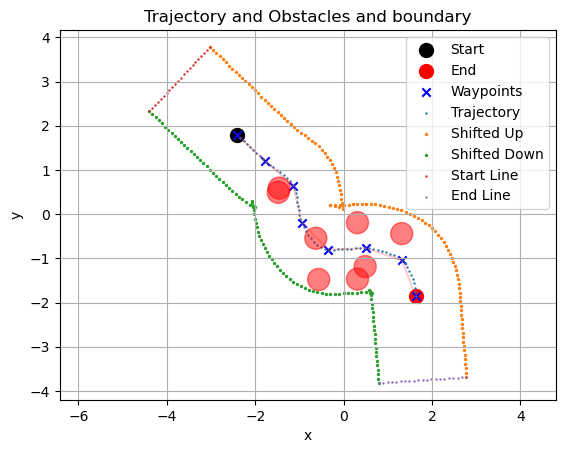

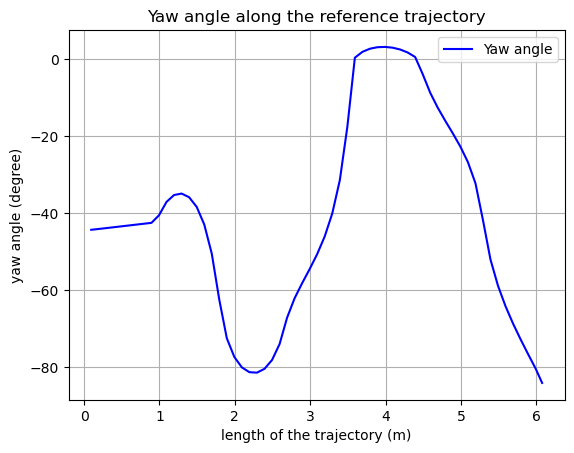

In [258]:
testPath = Path(trajectory_point_interval=0.1,
                No=8, Nw=8, Lp=6, mu_r=0.25, sigma_d=0.8, shift_distance=1)
testPath.reset()
testPath.render(if_yaw_angle=True)
testPath.print_shape()

#### Save the path

In [259]:
with open("testPath.pkl", "wb") as file:
    pickle.dump(testPath, file)

### Load saved path

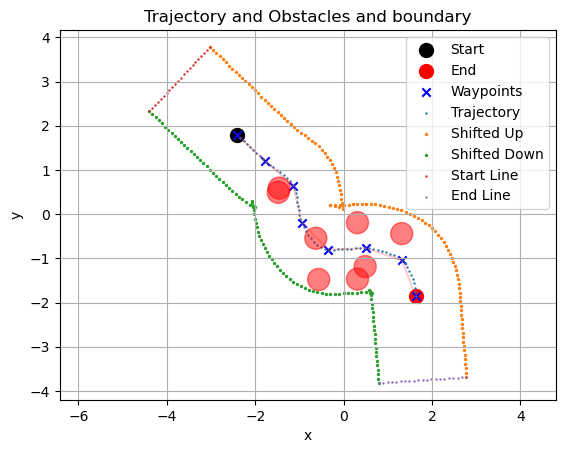

In [6]:
with open("testPath.pkl", "rb") as file:
    testPath:Path = pickle.load(file)
testPath.render(if_yaw_angle=False)

### query point

[s, e] = [-0.085 -0.21 ]
lool ahead point:[ 1.235 -0.983]
target angle: -26.697469528730636
angle_diff: -16.697469528730636
look_ahead_course_error: -16.69746952873065
course_error: 10.805870309635084


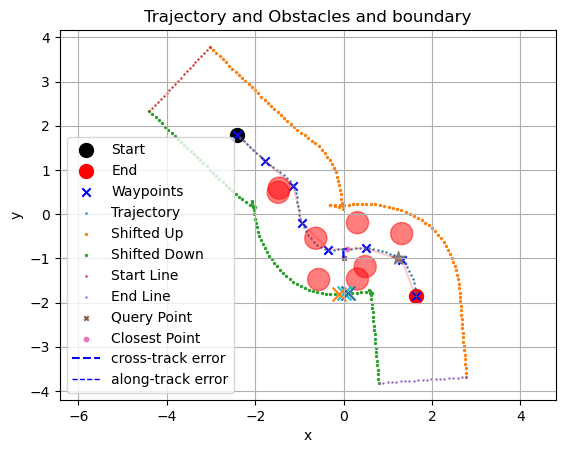

In [25]:
heading = -10
# query_point = np.array([-3.0, 2.5]) # smallest penalty
# query_point = np.array([-2.0, 1.2])
query_point = np.array([-0.2, -1.2])
query_point = np.array([0.0, -1.0])  # largest penalty
atr_state = np.array([query_point[0], query_point[1], np.deg2rad(heading)])

num_of_closest_points = 3
eta, index_of_the_closest_point, look_ahead_point, target_point_yaw, look_ahead_course_error, course_error = testPath.calculate_error_vector(atr_state)
min_distance_to_walls, closest_point_on_walls = testPath.minimum_distance_to_walls(query_point, method='kdtree', num_of_closest_points=num_of_closest_points)

testPath.render(if_yaw_angle=False)
print(f"[s, e] = {eta}")
print(f"lool ahead point:{look_ahead_point}")
plt.scatter(look_ahead_point[0],look_ahead_point[1], s=100, marker='*', label='Target Point')
plt.scatter(closest_point_on_walls[1][0], closest_point_on_walls[1][1], s=100, marker='x', label='Closest Point on Walls')
for i in range(num_of_closest_points):
    plt.scatter(closest_point_on_walls[i][0], closest_point_on_walls[i][1], s=100, marker='x', label='Closest Point on Walls')

# atr_current_yaw_fake = testPath.yaw_angles[index_of_the_closest_point]
# print(f"current angle: {np.rad2deg(atr_current_yaw_fake)}")
print(f"target angle: {np.rad2deg(target_point_yaw)}")
angle_diff = target_point_yaw - np.deg2rad(heading)
print(f"angle_diff: {np.rad2deg(angle_diff)}")
print(f"look_ahead_course_error: {np.rad2deg(look_ahead_course_error)}")
print(f"course_error: {np.rad2deg(course_error)}")

### clossness calculation

In [9]:
# Function to draw an arrow
def draw_arrow(x, y, angle, length=1, color='b'):
    dx = length * np.cos(angle)
    dy = length * np.sin(angle)
    
    plt.arrow(x, y, dx, dy, head_width=0.05, head_length=0.1, fc=color, ec='black')
    
# query_point = np.array([-3.0, 0.0])
# num_of_closest_points = 3
# eta, index_of_the_closest_point, look_ahead_point, target_point_yaw = testPath.calculate_error_vector(query_point)
# min_distance_to_walls, closest_point_on_walls = testPath.minimum_distance_to_walls(query_point, method='kdtree', num_of_closest_points=num_of_closest_points)

atr_current_yaw_fake = testPath.yaw_angles[index_of_the_closest_point]
atr_state = np.array([query_point[0], query_point[1], atr_current_yaw_fake])

# Parameters
distance_threshold = 1.0 # aka senser range
sensor_angle = 120
nsectors = 20
num_points_on_obstacles = 5

angle_threshold = np.deg2rad(sensor_angle)
sector_bound_angle = np.deg2rad(sensor_angle)

narrow_angle = np.deg2rad(120) # angles on the circle, how much from the angle difference to the starting bound
angle_inbetween = np.deg2rad(120) # angles on the circle, how much between the starting bound and the ending bound

def closeness_cal(render=False):

    # Generate fake sensor data
    circles = testPath.obstacles_np.copy()
    # Point and its heading angle
    point = atr_state.copy()
    # Discretize theta    
    distances = []
    angle_diffs = []
    angle_diffs_global = []
    obstacles_obs = []
    
    # For each circle
    for circle in circles:
        h, k, r = circle
        # calculate the closest distance
        x_obs = h - point[0]
        y_obs = k - point[1]
        dm = np.sqrt(x_obs**2 + y_obs**2) - r
        if dm > distance_threshold:
            continue
        angle_diff = np.arctan2(k - point[1], h - point[0])
        start_angle = angle_diff + narrow_angle
        end_angle = start_angle + angle_inbetween
        thetas = np.linspace(start_angle, end_angle, num_points_on_obstacles)
        # Calculate x and y for each theta
        xs = h + r * np.cos(thetas)
        ys = k + r * np.sin(thetas)

        # Calculate distances for each (x, y)
        distance = np.sqrt((point[0] - xs)**2 + (point[1] - ys)**2)
        distances.append(distance)

        # Calculate angle differences
        # Relative angle from x axis to obstacle
        angles = np.arctan2(ys - point[1], xs - point[0])
        angle_diffs_global.append(angles)
        
        # The relative angle from car to obstacle
        # make sure the relative angle is betwen -pi to pi
        angle_diff = angles - point[2]
        angle_diff = np.remainder(angle_diff + np.pi, 2 * np.pi) - np.pi
        angle_diffs.append(angle_diff)

    # Add points on the walls to the obstacles_obs
    for distance, wallp in zip(min_distance_to_walls, closest_point_on_walls):
        angles = np.arctan2(wallp[1] - point[1], wallp[0] - point[0])
        angle_diffs_global.append(angles)
        
        # angle_diff = angles - point[2]
        angle_diff = angles - point[2]
        angle_diff = np.remainder(angle_diff + np.pi, 2 * np.pi) - np.pi
        angle_diffs.append(angle_diff)
        distances.append(distance)

    distances = np.hstack(distances)
    distances = distances.flatten()
    angle_diffs = np.hstack(angle_diffs)
    angle_diffs = angle_diffs.flatten()
    angle_diffs_global = np.hstack(angle_diffs_global)
    angle_diffs_global = angle_diffs_global.flatten()

    for idx, distance in enumerate(distances):
        if distance < distance_threshold and np.abs(angle_diffs[idx]) < angle_threshold:
            obstacles_obs.append([distance, angle_diffs[idx], angle_diffs_global[idx]])
    
        
    # obstacles_obs: distance|angle differs|angle differs global|index of the closest point on the walls
    # Generate Sectors
    num_of_sectors = nsectors + 1
    # Create an array of angles from -pi to pi, separated by 10 degrees each
    sectors = np.linspace(-sector_bound_angle, sector_bound_angle, num_of_sectors)
    # Create an array to store the extracted data based on the sectors
    result = np.zeros(num_of_sectors)
    counts = np.zeros(num_of_sectors)
    differences = np.diff(sectors)
    angles_of_sectors = sectors[:-1] + differences / 2
    if len(obstacles_obs) != 0:
        obstacles_obs = np.array(obstacles_obs).reshape(-1, 3)
        # Pooling data in each sector
        # Iterate over each angle in the measurement data and find the corresponding sector
        for data in obstacles_obs:
            
            # Find the index of the sector in which the angle falls
            sector_index = np.searchsorted(sectors, data[1])

            # Add the distance value to the corresponding sector in the result array
            result[sector_index] += data[0]
            counts[sector_index] += 1
        
        # averaging pooling
        result = np.divide(result, counts, out=np.zeros_like(result), where=counts!=0)
        result = result[1:]
        result = np.where(result == 0, distance_threshold, result)
        
        # take the middle angle of each sector
        
        mes = np.vstack([angles_of_sectors, result]).T
        closeness = 1-1*result
    else:
        result = np.ones(num_of_sectors-1) * distance_threshold
        mes =  np.vstack([angles_of_sectors, result]).T
        closeness = np.zeros(nsectors)
    ## PLOT
    if render:
        # Draw measurements and sectors
        fig, ax = plt.subplots()
        for angle in sectors:
            draw_arrow(0.0, 0.0, angle, 1.0)        
        for data in mes:
            draw_arrow(0.0, 0.0, data[0], data[1], 'r')
        plt.axis("equal")
        
        
        
        fig, ax = plt.subplots()
        i = 0
        for p_obst, r_obst in testPath.obstacles:
            circle = plt.Circle((p_obst[0], p_obst[1]), r_obst, color='r', alpha=0.5)
            plt.text(p_obst[0], p_obst[1], f"r={i}", fontsize=10)
            plt.gca().add_patch(circle)
            i += 1
        for i, obs in enumerate(obstacles_obs):
            draw_arrow(atr_state[0], atr_state[1], obs[2], obs[0])
        # draw_arrow(atr_state[0], atr_state[1], obstacles_obs[4][2], obstacles_obs[4][0])
        draw_arrow(atr_state[0], atr_state[1], atr_state[2], 1.0, color='r')
        plt.axis("equal")

        fig, ax = plt.subplots()
        plt.bar(np.rad2deg(angles_of_sectors), closeness)
    return closeness, obstacles_obs


closeness: [0.    0.664 0.389 0.399 0.395 0.    0.557 0.    0.671 0.455 0.559 0.
 0.455 0.    0.    0.078 0.099 0.    0.    0.308]
obstacles_obs: [[ 0.692  2.009  1.834]
 [ 0.602  0.561  0.387]
 [ 0.487  0.453  0.279]
 [ 0.437  0.193  0.019]
 [ 0.487 -0.066 -0.241]
 [ 0.602 -0.174 -0.349]
 [ 0.922  1.41   1.236]
 [ 0.88   1.274  1.1  ]
 [ 0.922  1.138  0.964]
 [ 0.399 -1.742 -1.917]
 [ 0.274 -1.842 -2.016]
 [ 0.503  0.136 -0.039]
 [ 0.383  0.023 -0.152]
 [ 0.329 -0.309 -0.484]
 [ 0.383 -0.642 -0.816]
 [ 0.503 -0.754 -0.929]
 [ 0.601 -1.399 -1.573]
 [ 0.605 -1.233 -1.407]
 [ 0.611 -1.563 -1.738]]


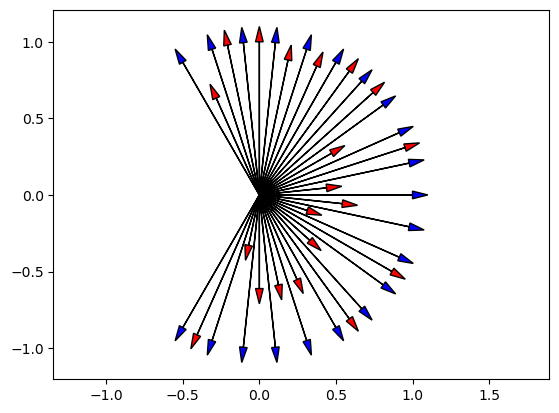

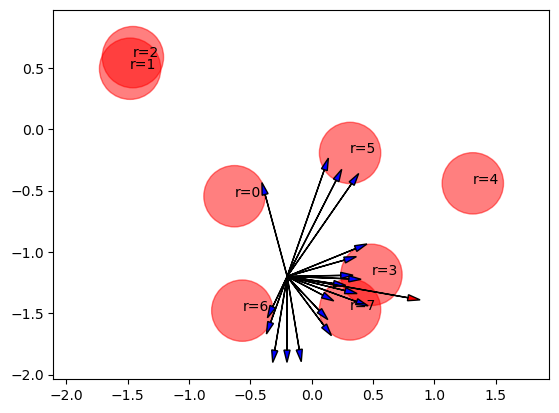

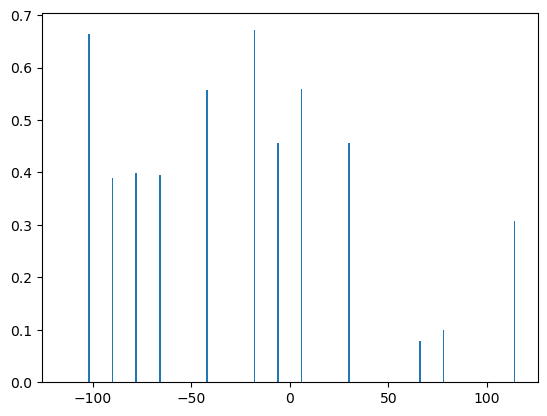

In [21]:
closeness, obstacles_obs = closeness_cal(render=True)
print(f"closeness: {closeness}")
print(f"obstacles_obs: {obstacles_obs}")

#### time cost

In [170]:
stime = time.time()
# length of the trajectory is 6.0 m
# maximum speed of atr is 0.1 m/s
# thus it needs 60 seconds to finish the trajectory
# training step is 0.1 second
# thus it needs 600 steps to finish the trajectory

iterations = 1000
for i in range(iterations):
    query_point = np.array([-1.0, 0.3])
    atr_current_yaw_fake = testPath.yaw_angles[index_of_the_closest_point]
    num_of_closest_points = 3
    eta, index_of_the_closest_point, look_ahead_point, target_point_yaw = testPath.calculate_error_vector(query_point)
    min_distance_to_walls, closest_point_on_walls = testPath.minimum_distance_to_walls(query_point, method='kdtree', num_of_closest_points=num_of_closest_points)
    atr_state = np.array([query_point[0], query_point[1], atr_current_yaw_fake])
    closeness = closeness_cal(render=False)
etime = time.time()
print(f"Time used: {etime - stime}")
print(f"Average time used: {(etime - stime)/iterations}")


Time used: 0.8113617897033691
Average time used: 0.0008113617897033691


### Rewards
- r_oa: obstacle avoidance reward
- r_pf: path following reward
- r_exi: existence reward

#### Obstacle avoid performance 

$r_{oa} = \frac{\Sigma_{i=1}^{N}(1+|\gamma_{\theta}\theta_{i}|)^{-1}(\gamma_{x}max(x_i, \epsilon_x)^{2})^{-1}}{N}$ 

The reward for ostacles are simply the average of the sensor measurements. Not the weighted averge as in the paper.
When there's no obstacles detected, it will simply return the reward for detecting an obstacle at (pi, 5.0)

In [22]:
gamma_theta = 4.0
gamma_x = 0.1
den = 0.0
num = 0.0
penalties = 0.0
r_oa = 0.0
if len(obstacles_obs) == 0:
    print("no obstacles")
    # num = (1 + np.abs(gamma_theta * np.pi)) ** -1 * (gamma_x * np.maximum(10.0, 0.2)**2) ** -1
    # den = (1 + np.abs(gamma_theta * np.pi)) ** -1
    # r_oa = - num/den
    
    r_oa -= (1 + np.abs(gamma_theta * np.pi)) ** -1 * (gamma_x * 5**2) ** -1
else:
    for idx, data in enumerate(obstacles_obs):
        num += ((1 + np.abs(gamma_theta * data[1])) ** -1) * ((gamma_x * np.maximum(data[0], 0.1)**2) ** -1)
        den += ( 1 + np.abs(gamma_theta * data[1])) ** -1
        # r_oa -= np.log((1 + np.abs(gamma_theta * data[1])) ** -1 * (gamma_x * np.maximum(data[0], 0.1)**2) ** -1)
        # r_oa -= (1 + np.abs(gamma_theta * data[1])) ** -1 * (gamma_x * np.maximum(data[0], 0.1)**2) ** -1
        
        # num += ((1 + np.abs(gamma_theta * data[1])) ** -1) * (np.log(np.abs(gamma_x)) + 2 * np.log(np.maximum(data[0], 0.1)))
        # den += (1 + np.abs(gamma_theta * data[1])) ** -1
    # r_oa /= len(obstacles_obs)
    r_oa = - num/den
    # r_oa = np.log(r_oa)
print(r_oa)

-47.3042413045008


#### path following performance
$r_{pf}(t)=-1+(\frac{v}{U_{max}}cos\tilde{\chi}(t)+1)(e^{-\gamma_e|y_e(t)|+1})$  
$U_{max}=0.1 m/s$

In [26]:
gammma_e = 0.5
gamma_theta = 10
v = 0.8
print(f"heading: {heading}")
print(f"course_error: {np.rad2deg(course_error)}")
print(f"look_ahead_course_error: {np.rad2deg(look_ahead_course_error)}")
print(f"along-track error: {eta[0]}")
print(f"cross-track error: {eta[1]}")
reward = -1 + (1 * np.cos(course_error)+1) * (np.exp(-gammma_e * np.abs(eta[1]) + 1))
reward *= 3
print(f"reward: {reward}")

heading: -10
course_error: 10.805870309635084
look_ahead_course_error: -16.69746952873065
along-track error: -0.08512787244676576
cross-track error: -0.20959209497775982
reward: 11.556795200783991


## Trash

### Obstacles pooling

In [145]:
from copy import deepcopy
tempPath = deepcopy(testPath)
atr_state = np.array([query_point[0], query_point[1], atr_current_yaw_fake])
print(atr_state)

[-1.     0.5   -0.853]


In [146]:
# Function to draw an arrow
def draw_arrow(x, y, angle, length=1, color='b'):
    dx = length * np.cos(angle)
    dy = length * np.sin(angle)
    
    plt.arrow(x, y, dx, dy, head_width=0.05, head_length=0.1, fc=color, ec='black')

#### Fake sensor

In [ ]:
distance_threshold = 1.0
angle_threshold = np.deg2rad(120)
# Circle parameters
# circles = np.array([[0,0,1],[1,1,1],[2,2,1],[3,3,1],[4,4,1],[5,5,1],[6,6,1],[7,7,1]])  # example values
circles = testPath.obstacles_np.copy()
# Point and its heading angle
# point = np.array([2, 2, np.pi/4])  # example values
# query_point = np.array([2.0, -1.0]) # 2.0, -1.0
# atr_state = np.array([query_point[0], query_point[1], atr_current_yaw_fake])
point = atr_state.copy()
# Discretize theta
thetas = np.linspace(0, 2*np.pi, 10)

stime = time.time()

# for i in range(2000):
distances = []
angle_diffs = []
angle_diffs_global = []
obstacles_obs = []


# For each circle
for circle in circles:
    h, k, r = circle
    # calculate the closest distance
    x_obs = h - point[0]
    y_obs = k - point[1]
    dm = np.sqrt(x_obs**2 + y_obs**2) - r
    if dm > distance_threshold:
        continue
    angle_diff = np.arctan2(k - point[1], h - point[0])
    narrow_angle = np.deg2rad(120)
    angle_inbetween = np.deg2rad(120)
    start_angle = angle_diff + narrow_angle
    end_angle = start_angle + angle_inbetween
    thetas = np.linspace(start_angle, end_angle, 5)
    # Calculate x and y for each theta
    xs = h + r * np.cos(thetas)
    ys = k + r * np.sin(thetas)

    # Calculate distances for each (x, y)
    distance = np.sqrt((point[0] - xs)**2 + (point[1] - ys)**2)
    distances.append(distance)

    # Calculate angle differences
    # Relative angle from x axis to obstacle
    angles = np.arctan2(ys - point[1], xs - point[0])
    angle_diffs_global.append(angles)
    
    # The relative angle from car to obstacle
    # make sure the relative angle is betwen -pi to pi
    angle_diff = angles - point[2]
    angle_diff = np.remainder(angle_diff + np.pi, 2 * np.pi) - np.pi
    angle_diffs.append(angle_diff)

for distance, wallp in zip(min_distance_to_walls, closest_point_on_walls):
    angles = np.arctan2(wallp[1] - point[1], wallp[0] - point[0])
    angle_diffs_global.append(angles)
    
    # angle_diff = angles - point[2]
    angle_diff = angles - point[2]
    angle_diff = np.remainder(angle_diff + np.pi, 2 * np.pi) - np.pi
    angle_diffs.append(angle_diff)
    distances.append(distance)
    
# print(min_distance_to_walls)
print(distances)

distances = np.hstack(distances)
distances = distances.flatten()
angle_diffs = np.hstack(angle_diffs)
angle_diffs = angle_diffs.flatten()
angle_diffs_global = np.hstack(angle_diffs_global)
angle_diffs_global = angle_diffs_global.flatten()

# obstacles_obs = np.stack([distances, angle_diffs, angle_diffs_global], axis=1)
for idx, distance in enumerate(distances):
    # distance_threshold = 1.0
    # angle_threshold = np.deg2rad(120)
    if distance < distance_threshold and np.abs(angle_diffs[idx]) < angle_threshold:
        obstacles_obs.append([distance, angle_diffs[idx], angle_diffs_global[idx], idx])
if len(obstacles_obs) == 0:
    obstacles_obs.append([3.0, np.pi, np.pi, 0])
obstacles_obs = np.array(obstacles_obs).reshape(-1, 4)

etime = time.time()
print(f"Time used: {etime - stime}")
print(obstacles_obs)

# PLOT
i = 0
for p_obst, r_obst in tempPath.obstacles:
    circle = plt.Circle((p_obst[0], p_obst[1]), r_obst, color='r', alpha=0.5)
    plt.text(p_obst[0], p_obst[1], f"r={i}", fontsize=10)
    plt.gca().add_patch(circle)
    i += 1
for i, obs in enumerate(obstacles_obs):
    draw_arrow(atr_state[0], atr_state[1], obs[2], obs[0])
# draw_arrow(atr_state[0], atr_state[1], obstacles_obs[4][2], obstacles_obs[4][0])
draw_arrow(atr_state[0], atr_state[1], atr_state[2], 1.0, color='r')
plt.axis("equal")
print(obstacles_obs.shape)
print(atr_state[2])

#### Sectors

In [ ]:
print(obstacles_obs.shape)
# obstacles_obs[0]: distance
# obstacles_obs[1]: angle differs
sectors = np.linspace(0, np.pi, 10)
obstacles_obs_tmp = obstacles_obs
# obstacles_obs = np.array([[1.0, 0.087],
#                           [1.0, 0.524],
#                           [1.0, 1.578],
#                           [3.0, 1.578],
#                           [1.0, -1.91986]])
num_of_sectors = 20 + 1
data_in_sectors = np.zeros(num_of_sectors)
# Assuming you have the measurement data in a numpy array named 'data' with shape (8, 4)
# data = np.random.rand(8, 4)  # Random data for illustration purposes

# Create an array of angles from -pi to pi, separated by 10 degrees each
sectors = np.linspace(-np.deg2rad(120), np.deg2rad(120), num_of_sectors)
print(np.rad2deg(sectors))

# Create an array to store the extracted data based on the sectors
result = np.zeros(num_of_sectors)
counts = np.zeros(num_of_sectors)

# Iterate over each angle in the measurement data and find the corresponding sector
for data in obstacles_obs:
    
    # Find the index of the sector in which the angle falls
    sector_index = np.searchsorted(sectors, data[1])

    # Add the distance value to the corresponding sector in the result array
    result[sector_index] += data[0]
    counts[sector_index] += 1
result = np.divide(result, counts, out=np.zeros_like(result), where=counts!=0)
result = result[1:]
result = np.where(result == 0, 1.0, result)
print(result)
print(len(result))
print(np.rad2deg(obstacles_obs[:,1]))

#### closeness

In [ ]:
differences = np.diff(sectors)
angles = sectors[:-1] + differences / 2
mes = np.vstack([angles, result]).T

pan = sectors
for data in mes:
    if data[1] !=0:
        draw_arrow(0.0, 0.0, data[0], data[1], 'r')
for angle in pan:
    draw_arrow(0.0, 0.0, angle, 1.0)
closeness = 1-1*result
print(closeness)
plt.axis("equal")

In [ ]:
gamma_theta = 4.0
gamma_x = 0.1
den = 0.0
num = 0.0

for idx, data in enumerate(obstacles_obs):
    den += ( 1 + np.abs(gamma_theta * data[1])) ** -1
    num += (1 + np.abs(gamma_theta * data[1])) ** -1 * (gamma_x * np.maximum(data[0], 0.5)**2) ** -1
r_oa = - num/den
print(r_oa)

-1.1111111111111112


In [ ]:
def gen_sensor(angle_min, angle_max, distance_min, distance_max, num_samples):
    # First dimension: random numbers from -pi to pi
    dim1 = np.random.uniform(angle_min, angle_max, num_samples)

    # Second dimension: random numbers from 0.1 to 5
    dim2 = np.random.uniform(distance_min, distance_max, num_samples)

    # Stack these two 1D arrays into a 2D array
    result = np.column_stack((dim1, dim2))
    sorted_result = result[result[:,0].argsort()]

    for data in sorted_result:
        draw_arrow(0.0, 0.0, data[0], data[1])
    return sorted_result

data = gen_sensor(-np.pi/2, np.pi/2, 0.1, 5.0, 20)
print(data)


### Cheeck if a point is inside the polygon

In [ ]:
from shapely.geometry import Polygon, Point
bounding_box_polygon = Polygon(np.vstack([testPath.wall_up, testPath.wall_down, testPath.start_line, testPath.end_line]))
point = np.array([-4, -5])
isinside = testPath.is_inside(point)
if isinside:
    print("inside")
else:
    print("outside")

outside


In [ ]:
walls = [testPath.wall_up, testPath.wall_down, testPath.start_line, testPath.end_line]
walls_kdTree = np.vstack([testPath.wall_up, testPath.wall_down, testPath.start_line, testPath.end_line])
# print(walls)
# print(walls_kdTree)

Computation time: 0.00184 seconds
Computation time: 0.00281 seconds


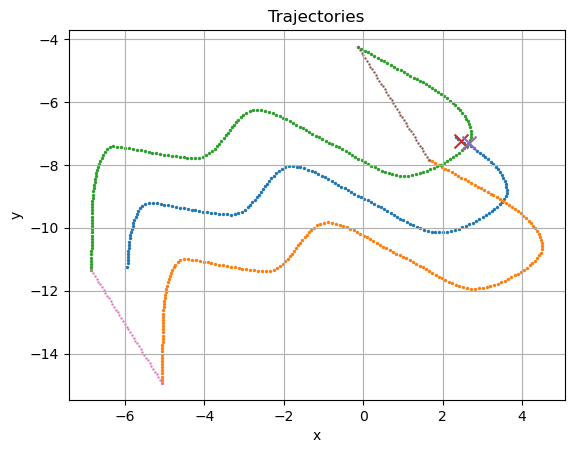

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import time

def average_direction(points):
    diff = np.diff(points, axis=0)
    avg_dir = np.mean(diff, axis=0)
    return avg_dir / np.linalg.norm(avg_dir)

def orthogonal_vector(vector):
    return np.array([-vector[1], vector[0]])

def shift_trajectory(points, distance, direction):
    return points + distance * direction

def distance_to_trajectories(point, trajectories):
    min_distance = float('inf')
    closest_trajectory = -1
    closest_point_index = -1

    for i, trajectory in enumerate(trajectories):
        distances = np.linalg.norm(trajectory - point, axis=1)
        current_min_distance = np.min(distances)
        current_closest_point_index = np.argmin(distances)

        if current_min_distance < min_distance:
            min_distance = current_min_distance
            closest_trajectory = i
            closest_point_index = current_closest_point_index

    return min_distance, closest_trajectory, closest_point_index

def extend_trajectory(points, extend_length):
    
    if extend_length == 0:
        return points
    
    distance = np.linalg.norm(points[3] - points[2])
    start_direction = (points[1] - points[0]) / np.linalg.norm(points[1] - points[0])
    end_direction = (points[-1] - points[-2]) / np.linalg.norm(points[-1] - points[-2])
    num_points_to_add = int(extend_length / distance)
    start_points = [points[0] - start_direction * distance * i for i in range(1, num_points_to_add + 1)][::-1]
    end_points = [points[-1] + end_direction * distance * i for i in range(1, num_points_to_add + 1)]

    return np.vstack([start_points, points, end_points])

def create_line_between_points(point_a, point_b, point_distance=0.1):
    distance = np.linalg.norm(point_b - point_a)
    num_points = int(np.ceil(distance / point_distance)) + 1
    t = np.linspace(0, 1, num_points)
    line_points = np.array([(1 - t_i) * point_a + t_i * point_b for t_i in t])
    return line_points

# Example usage:
# points = np.array([(0, 0), (1, 1), (2, 0), (3, 1), (4, 0)])
points = testPath.even_trajectory.copy()

distance = 2

avg_dir = average_direction(points)
orthogonal_dir = orthogonal_vector(avg_dir)

shifted_points_up = shift_trajectory(points, distance, orthogonal_dir)
shifted_points_down = shift_trajectory(points, -distance, orthogonal_dir)

# Extend the trajectories
extend_length = 2
extended_shifted_points_up = extend_trajectory(shifted_points_up, extend_length)
extended_shifted_points_down = extend_trajectory(shifted_points_down, extend_length)

# Create lines connecting the starting points and ending points
start_line = create_line_between_points(extended_shifted_points_up[0], extended_shifted_points_down[0], point_distance=0.1)
end_line = create_line_between_points(extended_shifted_points_up[-1], extended_shifted_points_down[-1], point_distance=0.1)




# Closest point
sample_indexs = np.random.choice(points.shape[0], 20)
query_points = minimum_distance_to_walls(self, point,'kdtree')

trajectories = [extended_shifted_points_up, extended_shifted_points_down, start_line, end_line]
# query_point = np.array([0.0, 0.0])
start_time = time.time()
for query_point in query_points:
    min_distance, closest_trajectory_index, closest_point_index = distance_to_trajectories(query_point, trajectories)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Computation time: {elapsed_time:.5f} seconds")


# Closet point using cKDTree
start_time = time.time()
all_new_trajectories = np.vstack([extended_shifted_points_up, extended_shifted_points_down, start_line, end_line])
# Store the starting indices of each trajectory in the combined array
starting_indices = [0, len(extended_shifted_points_up), 
                    len(extended_shifted_points_up) + len(extended_shifted_points_down), 
                    len(extended_shifted_points_up) + len(extended_shifted_points_down) + len(start_line)]
# Create a k-d tree
kd_tree = cKDTree(all_new_trajectories)
for query_point in query_points:
    # Query the k-d tree for the nearest point
    min_distance, index = kd_tree.query(query_point)
    closest_trajectory_index = np.searchsorted(starting_indices, index, side="right") - 1
    closest_point_index = index - starting_indices[closest_trajectory_index]
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Computation time: {elapsed_time:.5f} seconds")

# Plot the trajectories
plt.scatter(points[:, 0], points[:, 1], s=2, marker='o', label='Original')
plt.scatter(extended_shifted_points_up[:, 0], extended_shifted_points_up[:, 1], s=2, marker='o', label='Shifted Up')
plt.scatter(extended_shifted_points_down[:, 0], extended_shifted_points_down[:, 1], s=2, marker='o', label='Shifted Down')

plt.scatter(query_point[0], query_point[1], s=100, marker='x', label='Query Point')
plt.scatter(trajectories[closest_trajectory_index][closest_point_index, 0], trajectories[closest_trajectory_index][closest_point_index, 1], s=100, marker='x', label='Closest Point')

plt.scatter(start_line[:, 0], start_line[:, 1], s=2, marker='.', label='Start Line')
plt.scatter(end_line[:, 0], end_line[:, 1], s=2, marker='.', label='End Line')

# plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectories')
plt.grid()
plt.show()

In [ ]:
points = testPath.even_trajectory.copy()
distance = 1

In [ ]:
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
from scipy.integrate import cumtrapz

def local_orthogonal_directions(points):
    diff = np.diff(points, axis=0)
    normalized_diff = diff / np.linalg.norm(diff, axis=1, keepdims=True)
    orthogonal_directions = np.array([-normalized_diff[:, 1], normalized_diff[:, 0]]).T
    return orthogonal_directions

def shift_trajectory_local(points, distance, num_points=None):
    orthogonal_directions = local_orthogonal_directions(points)
    # Repeat the last orthogonal direction for the last point
    orthogonal_directions = np.vstack([orthogonal_directions, orthogonal_directions[-1, :]])
    shifted_points_up = points + distance * orthogonal_directions
    shifted_points_down = points - distance * orthogonal_directions

    if num_points is None:
        num_points = len(points)

    # Interpolate the shifted points to maintain even separation
    t_original = np.linspace(0, 1, len(points))
    t_new = np.linspace(0, 1, num_points)

    interpolator_up = interp1d(t_original, shifted_points_up, axis=0, kind='linear')
    interpolated_shifted_points_up = interpolator_up(t_new)

    interpolator_down = interp1d(t_original, shifted_points_down, axis=0, kind='linear')
    interpolated_shifted_points_down = interpolator_down(t_new)

    return interpolated_shifted_points_up, interpolated_shifted_points_down

def smooth_and_resample_trajectories(trajectory1, trajectory2, target_distance):
    def resample_trajectory(trajectory, target_distance):
        # Compute the distances between consecutive points
        distances = np.sqrt(np.sum(np.diff(trajectory, axis=0)**2, axis=1))
        # Compute the cumulative distance along the trajectory
        cum_dist = np.concatenate(([0], np.cumsum(distances)))
        total_distance = cum_dist[-1]

        # Calculate the number of new points for the resampled trajectory
        num_points = int(np.ceil(total_distance / target_distance))
        t_new = np.linspace(0, total_distance, num_points)

        # Interpolate the trajectory using cubic splines
        spline = CubicSpline(cum_dist, trajectory)
        resampled_trajectory = spline(t_new)

        return resampled_trajectory

    # Resample both trajectories with the target distance
    resampled_trajectory1 = resample_trajectory(trajectory1, target_distance)
    resampled_trajectory2 = resample_trajectory(trajectory2, target_distance)

    return resampled_trajectory1, resampled_trajectory2

# Shift the trajectories
shifted_points_up, shifted_points_down = shift_trajectory_local(points, distance)

# Smooth and resample the shifted trajectories
target_distance = 0.1
resampled_shifted_points_up, resampled_shifted_points_down = smooth_and_resample_trajectories(shifted_points_up, shifted_points_down, target_distance)

# Extend the resampled trajectories
extend_length = 2
extended_resampled_shifted_points_up = extend_trajectory(resampled_shifted_points_up, extend_length)
extended_resampled_shifted_points_down = extend_trajectory(resampled_shifted_points_down, extend_length)

# Create lines connecting the starting points and ending points
start_line = create_line_between_points(extended_resampled_shifted_points_up[0], extended_resampled_shifted_points_down[0], point_distance=0.1)
end_line = create_line_between_points(extended_resampled_shifted_points_up[-1], extended_resampled_shifted_points_down[-1], point_distance=0.1)


### Check if two trajectories crossed

In [ ]:
from shapely.geometry import Polygon, Point, LineString
new_trajectory_1 = testPath.even_trajectory
new_trajectory_2 = testPath.wall_up
new_trajectory_3 = testPath.wall_down
new_trajectory_4 = testPath.start_line
new_trajectory_5 = testPath.end_line

line1 = LineString(new_trajectory_1)
line2 = LineString(new_trajectory_2)
line3 = LineString(new_trajectory_3)
line4 = LineString(new_trajectory_4)
line5 = LineString(new_trajectory_5)

trajectory1 = [line1, line2, line3]
trajectory2 = [line1, line4, line5]
# Iterate through all possible pairs of trajectories
crossing = False
for i in range(len(trajectory1)):
    for j in range(i + 1, len(trajectory1)):
        if trajectory1[i].intersects(trajectory1[j]):
            crossing = True
            break
    if crossing:
        break
    
for i in range(len(trajectory2)):
    for j in range(i + 1, len(trajectory2)):
        if trajectory2[i].intersects(trajectory2[j]):
            crossing = True
            break
    if crossing:
        break
print("Do any two trajectories cross?", crossing)


Do any two trajectories cross? False


In [ ]:
sample_indexs = np.random.choice(testPath.even_trajectory.shape[0], 2000)
query_points = testPath.even_trajectory[sample_indexs] + np.random.normal(0, 0.4, size=(2000, 2))

In [ ]:
starttime = time.time()
for point in query_points:
    min_distance, closest_point = testPath.minimum_distance_to_walls(point)
endtime = time.time()
print(f"Time used: {endtime - starttime}")

Time used: 0.13954687118530273


In [ ]:
starttime = time.time()
for point in query_points:
    min_distance, closest_point = testPath.minimum_distance_to_walls(point, 'normal')
endtime = time.time()
print(f"Time used: {endtime - starttime}")

Time used: 0.3975870609283447


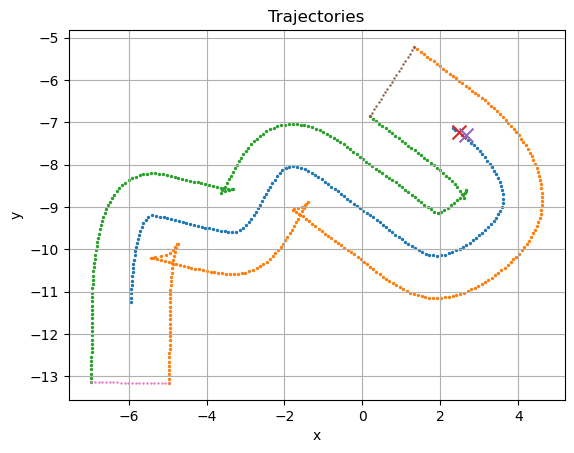

In [ ]:
plt.scatter(points[:, 0], points[:, 1], s=2, marker='o', label='Original')
plt.scatter(extended_resampled_shifted_points_up[:, 0], extended_resampled_shifted_points_up[:, 1], s=2, marker='o', label='Shifted Up')
plt.scatter(extended_resampled_shifted_points_down[:, 0], extended_resampled_shifted_points_down[:, 1], s=2, marker='o', label='Shifted Down')

plt.scatter(query_point[0], query_point[1], s=100, marker='x', label='Query Point')
plt.scatter(trajectories[closest_trajectory_index][closest_point_index, 0], trajectories[closest_trajectory_index][closest_point_index, 1], s=100, marker='x', label='Closest Point')

plt.scatter(start_line[:, 0], start_line[:, 1], s=2, marker='.', label='Start Line')
plt.scatter(end_line[:, 0], end_line[:, 1], s=2, marker='.', label='End Line')

# plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectories')
plt.grid()
plt.show()


In [ ]:
print(extended_resampled_shifted_points_up.shape)

(228, 2)


In [ ]:
distance_threshold = 1.0
angle_threshold = np.deg2rad(120)
obstacles_obs = []
arrows_obs = []

print(yaw)
for idx, obs in enumerate(tempPath.obstacles_np):
# for obs in tempPath.obstacles_np:
    y_obs = obs[1] - atr_state[1]
    x_obs = obs[0] - atr_state[0]
    r_obs = obs[2]
    yaw = atr_state[2]
    
    dm = np.sqrt(x_obs**2 + y_obs**2) - r_obs
    dl = dr = np.sqrt((dm+r_obs)**2 + r_obs**2)
    
    theta_m_global = np.arctan2(y_obs, x_obs)
    theta_l_global = theta_m_global + np.arctan2(r_obs, dm+r_obs)
    theta_r_global = theta_m_global - np.arctan2(r_obs, dm+r_obs)
    
    theta_m = theta_m_global - yaw
    theta_l = theta_l_global - yaw
    theta_r = theta_r_global - yaw
    
    if dm <= distance_threshold and np.abs(theta_m) <= angle_threshold:
        obstacles_obs.append([dm, theta_m, theta_m_global, idx])
        # arrows_obs.append(theta_m_global)
    if dl <= distance_threshold and np.abs(theta_l) <= angle_threshold:
        obstacles_obs.append([dl, theta_l, theta_l_global, idx])
        # arrows_obs.append(theta_l_global)
    if dr <= distance_threshold and np.abs(theta_r) <= angle_threshold:
        obstacles_obs.append([dr, theta_r, theta_r_global, idx])
        # arrows_obs.append(theta_r_global)
        
obstacles_obs = np.array(obstacles_obs).reshape(-1, 4)
print(obstacles_obs)


# PLOT
draw_arrow(atr_state[0], atr_state[1], yaw)
i = 0
for p_obst, r_obst in tempPath.obstacles:
    circle = plt.Circle((p_obst[0], p_obst[1]), r_obst, color='r', alpha=0.5)
    plt.text(p_obst[0], p_obst[1], f"r={i}", fontsize=10)
    plt.gca().add_patch(circle)
    i += 1
plt.axis("equal")
for i, obs in enumerate(obstacles_obs):
    draw_arrow(atr_state[0], atr_state[1], obs[2])
    

In [254]:
course_error = 7.0685
course_error = np.remainder(course_error + np.pi, 2 * np.pi) - np.pi
print(course_error)

0.785314692820414
